# Проект 5. Компьютер говорит НЕТ

## Цель проекта : Построить скоринговую модель предсказания дефолта клиентов банка и оценить ее качество.

##### Подгружаем библиотеки

In [47]:
import pandas as pd
import numpy as np
import pandas_profiling

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings; warnings.filterwarnings("ignore")
RANDOM_SEED = 40
!pip freeze > requirements.txt  

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, auc, mean_squared_error, roc_auc_score, \
roc_curve, accuracy_score, precision_score, recall_score, f1_score,precision_recall_curve,average_precision_score
import pandas_profiling


##### Загрузка датасета

In [48]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

Перед первичным просмотром и обработкой данных, объединим train и test выборки, предварительно пометив их

In [49]:
data_train['sample'] = 1
data_test['sample'] = 0
data_test['default'] = 0
data = data_test.append(data_train, sort=False).reset_index(drop=True)

##### Первичный просмотр данных и их типов

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [51]:
data.head()

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      74835  22MAR2014       GRD   M   29   Y        Y                0   
1      17527  24JAN2014       SCH   F   39   N        N                5   
2      75683  23MAR2014       UGR   M   50   Y        Y                0   
3      26883  03FEB2014       SCH   M   56   N        N                0   
4      28862  04FEB2014       GRD   F   38   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0  -2.271884                3             50             1   
1          0  -1.504999                2             50             1   
2          0  -1.691339                1             50             1   
3          0  -2.374182                1             40             1   
4          0  -2.487502                0             80             2   

   work_address  income  sna  first_time foreign_passport  sample  default  
0             2   50000    1           4                N       0        0  
1             2    5000    4           3                N       0        0  
2             2   30000    1           3                Y       0        0  
3             2   17000    1           3                N       0        0  
4             3  120000    1           3                N       0        0

In [10]:
data.describe()

client_id            age  decline_app_cnt      good_work  \
count  110148.000000  110148.000000    110148.000000  110148.000000   
mean    55074.500000      39.249410         0.273205       0.165514   
std     31797.133063      11.518063         0.799099       0.371645   
min         1.000000      21.000000         0.000000       0.000000   
25%     27537.750000      30.000000         0.000000       0.000000   
50%     55074.500000      37.000000         0.000000       0.000000   
75%     82611.250000      48.000000         0.000000       0.000000   
max    110148.000000      72.000000        33.000000       1.000000   

           score_bki  bki_request_cnt  region_rating   home_address  \
count  110148.000000    110148.000000  110148.000000  110148.000000   
mean       -1.904535         2.005002      56.751189       1.574945   
std         0.499397         2.266926      13.065923       0.527562   
min        -3.624586         0.000000      20.000000       1.000000   
25%        -2.260434         0.000000      50.000000       1.000000   
50%        -1.920823         1.000000      50.000000       2.000000   
75%        -1.567888         3.000000      60.000000       2.000000   
max         0.199773        53.000000      80.000000       3.000000   

        work_address          income            sna     first_time  \
count  110148.000000   110148.000000  110148.000000  110148.000000   
mean        2.497867    41012.648537       1.731588       2.765570   
std         0.687651    45399.735051       1.122652       1.010151   
min         1.000000     1000.000000       1.000000       1.000000   
25%         2.000000    20000.000000       1.000000       2.000000   
50%         3.000000    30000.000000       1.000000       3.000000   
75%         3.000000    48000.000000       2.000000       4.000000   
max         3.000000  1000000.000000       4.000000       4.000000   

              sample        default  
count  110148.000000  110148.000000  
mean        0.669999       0.085086  
std         0.470215       0.279010  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         1.000000       0.000000  
75%         1.000000       0.000000  
max         1.000000       1.000000

##### Анализ данных

In [11]:
pandas_profiling.ProfileReport(data)

##### Избавление от пропусков выбросов

Смотрим количество пропусков:

In [52]:
data.isna().sum(axis = 0)

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

Заменяем пропуски модой в признаке education

In [53]:
education_mode = data['education'].mode()[0]

In [54]:
data['education'].fillna(education_mode, inplace = True)

Интуитивно ясно, что количество отказанных прошлых заявок и дефолт связаны. Отобразим это на графике

Text(0.5, 1.0, 'Зависимость дефолта от количества отказанных прошлых заявок')

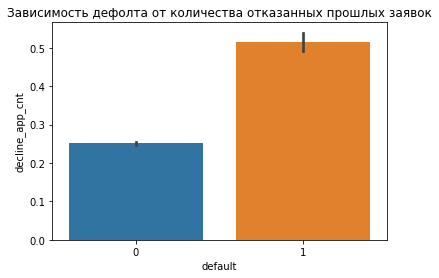

In [55]:
sns.barplot(x='default', 
            y ='decline_app_cnt',
            data=data).set_title('Зависимость дефолта от количества отказанных прошлых заявок')

Следовательно, опираясь на здравый смысл, 
принимаем решение не убирать признак "decline_app_cnt".(Несмотря на то, что анализ показал Zeros)
Но необходимо избавиться от выбросов.
Посмотрим внимательно еще раз на гистограмму распределения признака:

Text(0.5, 1.0, 'Гистограмма распределения decline_app_cnt')

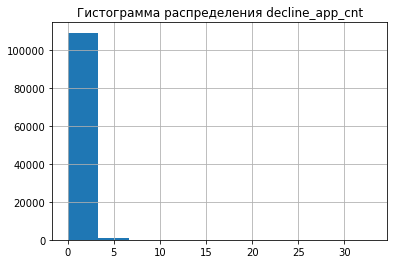

In [56]:
data['decline_app_cnt'].hist().set_title('Гистограмма распределения decline_app_cnt')

Text(0.5, 1.0, 'Гистограмма распределения decline_app_cnt(<=5)')

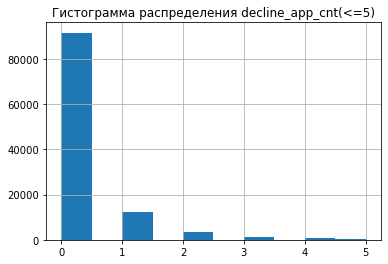

In [57]:
data[data['decline_app_cnt']<=5]['decline_app_cnt'].hist().set_title('Гистограмма распределения decline_app_cnt(<=5)')

Принимаем решение произвести категоризацию признака: (логистическая регрессия стабильно показывает чуть лучший результат)

In [58]:
data['decline_app_cnt'] = data['decline_app_cnt'].apply(lambda x: x if x<=2 else 2)

По остальным графикам видно, что, очевидно есть выбросы(с математической точки зрения). Например, 'income'. Но, подключая логику, нет оснований сомневаться, что есть заработные платы в 1 млн рублей. Метод IQR, безосновательно применять и к возрасту('age')

##### Распределим признаки по типу: категориальные, бинарные, числовые

In [59]:
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time',  'decline_app_cnt']
num_cols = ['age','income', 'bki_request_cnt', 'score_bki']

Числовые признаки

Рассмотрим еще раз графики распределения числовых признаков

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'income'}>],
       [<AxesSubplot:title={'center':'bki_request_cnt'}>,
        <AxesSubplot:title={'center':'score_bki'}>]], dtype=object)

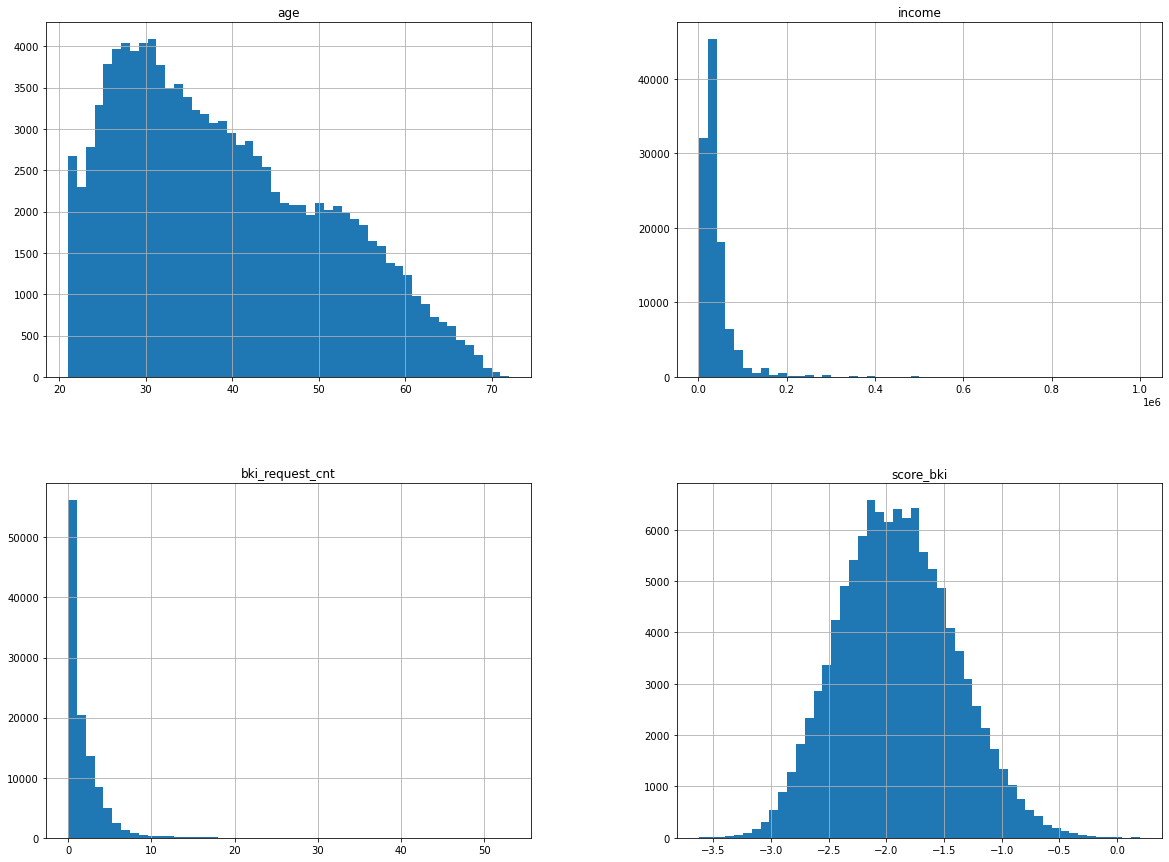

In [60]:
data[num_cols].hist(figsize = (20,15), bins= 50)

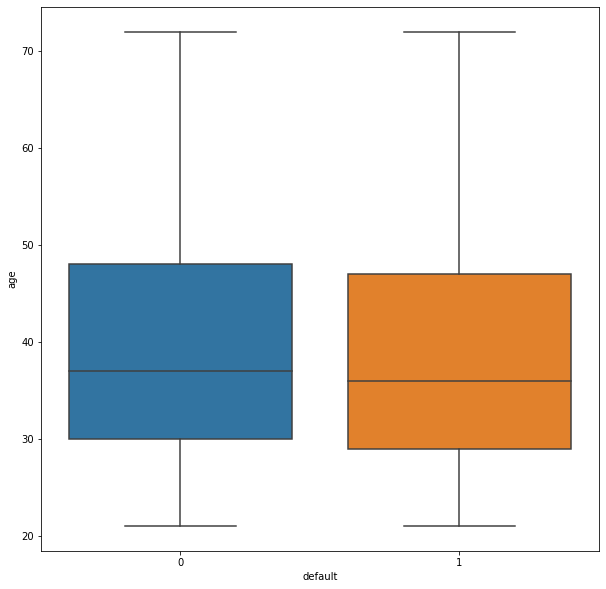

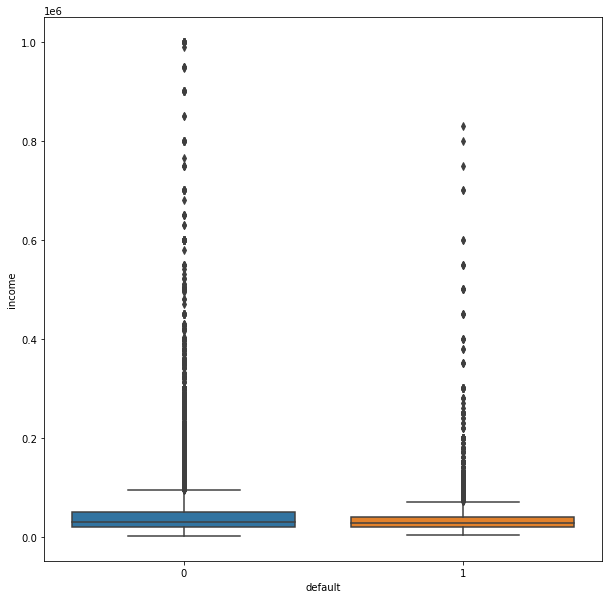

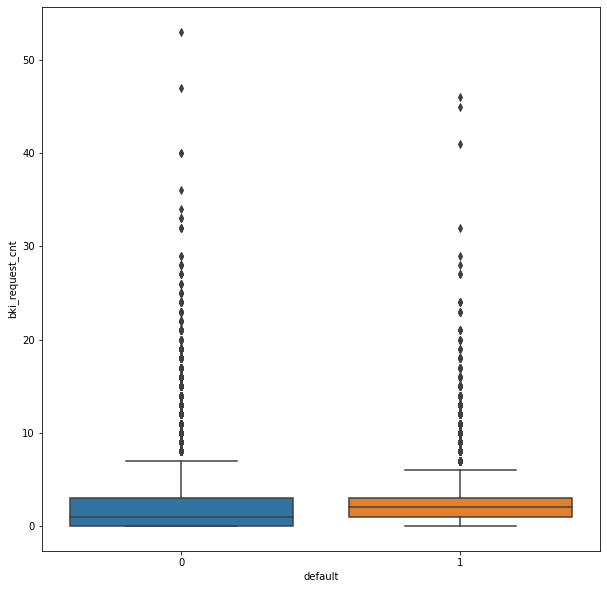

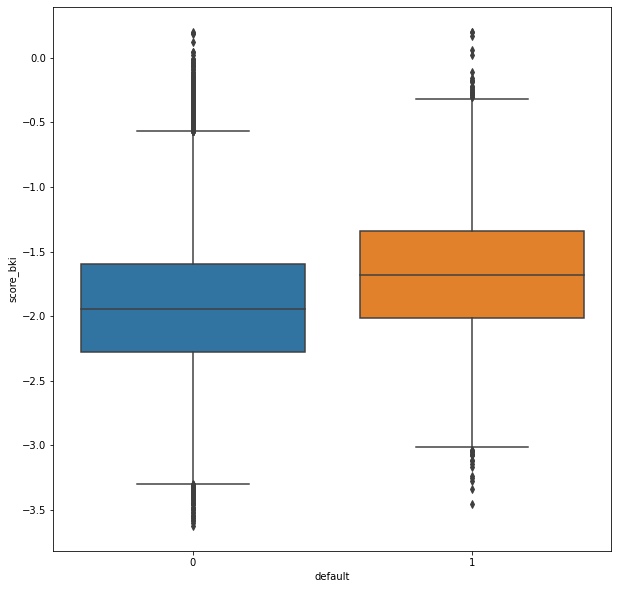

In [61]:
for i in num_cols:
    plt.figure(figsize = (10,10))
    sns.boxplot(x = data['default'], y = data[i], data = data)
    plt.show()

Категориальные признаки

Необходимо преобразование признака education к числовому формату. На всякий случай, создадим словарь для того, чтобы не потерять значения категорий:

In [62]:
education_values = data['education'].unique()

In [63]:
education_dict = {}

In [64]:
for i in range(len(education_values)):
    education_dict[education_values[i]] = i
    data['education'] = data['education'].replace(education_values[i], i)

In [65]:
education_dict

{'GRD': 0, 'SCH': 1, 'UGR': 2, 'PGR': 3, 'ACD': 4}

In [66]:
data['education']

0         0
1         1
2         2
3         1
4         0
         ..
110143    0
110144    1
110145    1
110146    1
110147    0
Name: education, Length: 110148, dtype: int64

##### Оценка корреляции

<AxesSubplot:>

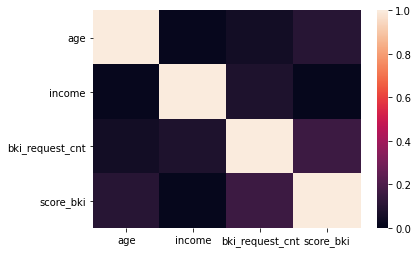

In [67]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

Корреляция между числовыми признаками отсутствует

##### Оценка значимости

Для оценки значимости числовых переменных будем исользуется функция f_classif

<AxesSubplot:>

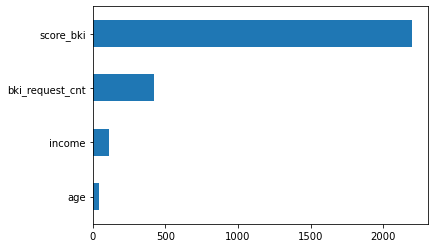

In [68]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Наиболее значимый признак - скоринговый балл по данным из БКИ, что логично

Категориальные признаки

Для бинарных признаков мы будем использовать LabelEncoder

In [69]:
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

<AxesSubplot:>

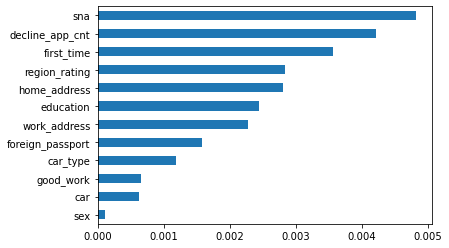

In [70]:
imp_cat = pd.Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')


Мы рассмотрели данные по возрасту заемщиков, хочется учесть риски дефолта при тяжелой болезни/смерти заемщика. Для этого с сайта https://rosinfostat.ru/prodolzhitelnost-zhizni/#i-2 возьмем информацию по продолжительности жизни во всех регионах Южного федерального округа(вначале проекта упоминается, что мы где-то на юге России). Данных немного, создадим dataset вручную

##### Подготовка данных к машинному обучению

Применяем метод get_dummies() для категориальных признаков

In [71]:
data = pd.get_dummies(data, columns=cat_cols)

In [72]:
data['sample']

0         0
1         0
2         0
3         0
4         0
         ..
110143    1
110144    1
110145    1
110146    1
110147    1
Name: sample, Length: 110148, dtype: int64

Выполним стандартизацию численных признаков

In [73]:
data[num_cols] = pd.DataFrame(StandardScaler().fit_transform(data[num_cols]), columns=num_cols)

Разделяем датасет на train и test (обучающая и тестовая выборки)

In [74]:
data_train = data[data['sample'] == 1].drop(['sample'], axis=1)
data_test = data[data['sample'] == 0].drop(['sample'], axis=1)

Убираем default - целевой признак, client_id, app_date 

In [75]:
X = data_train.drop(columns = ['default', 'client_id', 'app_date'])
Y = data_train['default']

Выделяем из обучающей выборки валидационную

In [76]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = RANDOM_SEED, test_size=0.2)

##### Построение модели и оценка качества

LogisticRegression

<Figure size 432x288 with 0 Axes>

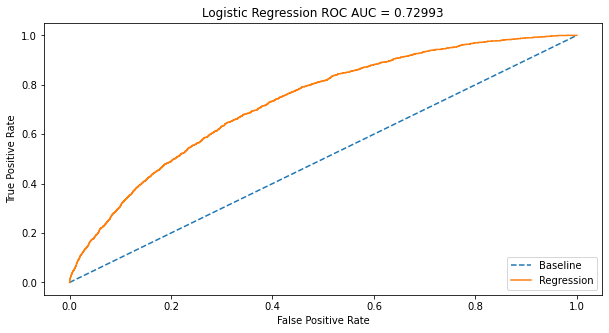

In [77]:
model_0 = LogisticRegression(max_iter = 1000)
model_0.fit(X_train, Y_train)
Y_pred = model_0.predict(X_test)
probs = model_0.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = roc_auc_score(Y_test, probs)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.5f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Считаем метрики:

In [78]:
print('accuracy_score: {}'.format(np.round(accuracy_score(Y_test, Y_pred), 5)))
print('f1_score: {}'.format(np.round(f1_score(Y_test, Y_pred), 5)))
print('recall_score: {}'.format(np.round(recall_score(Y_test, Y_pred), 5)))
print('MSE: {}'.format(np.round(mean_squared_error(Y_test, Y_pred), 5)))

accuracy_score: 0.87425
f1_score: 0.06263
recall_score: 0.03332
MSE: 0.12575


Confusion matrix:

In [79]:
cf_matrix = confusion_matrix(Y_test.values, Y_pred)

[Text(0.5, 15.0, 'predicted'),
 Text(33.0, 0.5, 'real'),
 Text(0.5, 1.0, 'Confusion matrix')]

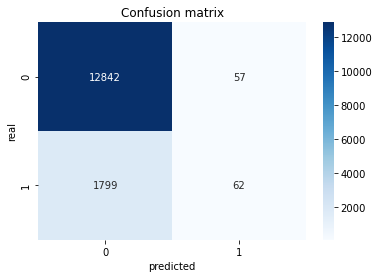

In [80]:
ax = sns.heatmap(cf_matrix, annot=True, 
            fmt='', cmap='Blues')
ax.set(xlabel='predicted', ylabel='real',title = 'Confusion matrix')

Вывод по LogisticRegression с параметрами по умолчанию. Несмотря на высокую точность модели, по матрице ошибок можно сказать, 
что имеет место быть ошибка первого рода. Банк выдаст кредит с большой вероятностью, 
в т.ч. ненадежным клиентам.

LogisticRegression(с гиперпараметрами)

Устанавливаем class_weight и подбираем параметры с помощью GridSearchCV.

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished


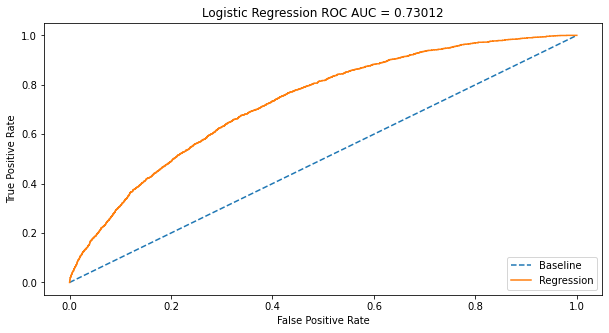

In [81]:
lr_best = LogisticRegression(class_weight = 'balanced', random_state=RANDOM_SEED)

params = {'C': np.linspace(0, 100, 5),
         'max_iter': np.linspace(start=1,stop=1000,num=10, dtype=int)}

model_best = GridSearchCV(lr_best, param_grid=params, verbose=1, cv=2)

model_best.fit(X_train, Y_train)
probs = model_best.predict_proba(X_test)
Y_pred = model_best.predict(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(Y_test, probs)
roc_auc = roc_auc_score(Y_test, probs)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
ax.set_title('Logistic Regression ROC AUC = %0.5f'%roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')

Считаем метрики:

In [82]:
print('accuracy_score: {}'.format(np.round(accuracy_score(Y_test, Y_pred), 5)))
print('f1_score: {}'.format(np.round(f1_score(Y_test, Y_pred), 5)))
print('recall_score: {}'.format(np.round(recall_score(Y_test, Y_pred), 5)))
print('MSE: {}'.format(np.round(mean_squared_error(Y_test, Y_pred), 5)))

accuracy_score: 0.67053
f1_score: 0.33629
recall_score: 0.66201
MSE: 0.32947


In [83]:
cf_matrix = confusion_matrix(Y_test.values, Y_pred)

[Text(0.5, 15.0, 'predicted'),
 Text(33.0, 0.5, 'real'),
 Text(0.5, 1.0, 'Confusion matrix')]

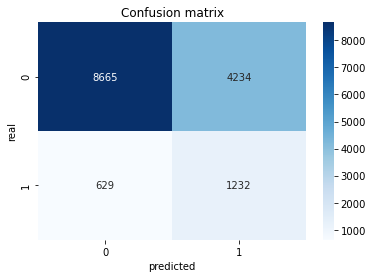

In [84]:
ax = sns.heatmap(cf_matrix, annot=True, 
            fmt='', cmap='Blues')
ax.set(xlabel='predicted', ylabel='real',title = 'Confusion matrix')

Вывод по LogisticRegression с гиперпараметрами. Несмотря на высокую точность модели, по матрице ошибок можно сказать, 
что имеет место быть ошибка второго рода. Банк с большой вероятностью откажет многим надежным клиентам.

##### Общий вывод

В целом, использование модели с гиперпараметрами выглядит логичнее и правильнее. Но лучше подобрать более точную модель и еще больше минимизировать ошибки.(Например, модель CatBoost).

Выгружаем submission

In [85]:
X_test2 = data_test.drop(columns = ['default', 'client_id','app_date'])
probs2 = model_best.predict_proba(X_test2)
Y_pred = model_best.predict(X_test2)
probs2 = probs2[:,1]
data_test['default'] = probs2

submission = data_test[['client_id','default']]

display(submission.shape)

(36349, 2)

In [46]:
submission.to_csv('submission.csv', index=False)